In [1]:
from CyRK import version
print(version)
import numpy as np
import TidalPy
TidalPy.clear_cache(verbose=False)

0.4.0a0.dev0


True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from TidalPy.toolbox.conversions import days2rads, rads2days, semi_a2orbital_motion
from TidalPy.rheology.complex_compliance.compliance_models import maxwell, sundberg, andrade
from TidalPy.tides.multilayer.numerical_int import radial_solver, tidal_y_solver_numba
from TidalPy.utilities.graphics.multilayer import yplot

R_Venus = 6050.0e3
M_Venus = 4.867e24
planet_bulk_density = M_Venus / ((4. / 3.) * np.pi * R_Venus**3)
venus_solar_day_freq = days2rads(1.)
solar_day_forcing_frequency = venus_solar_day_freq

# Build Domain
N = 40
# Start at a radius slightly larger than 0.
radius_array_baseline = np.linspace(10., R_Venus, N)

# Rheology Inputs
alpha_baseline, zeta_baseline, andrade_critical_freq_baseline = 0.3, 1., days2rads(10000.)
rheology_inputs_baseline = (alpha_baseline, zeta_baseline, andrade_critical_freq_baseline)

# Integration parameters
int_rtol_scale = 1.
int_atol_scale = .01
use_numba_integrator = True

# Incompressibility Check
incomp_bulk = 1.0e18

In [3]:
# Build function inputs
N = 100
radius_array = np.linspace(0.1, R_Venus, N)

use_dynamic_liquid = True

data = pd.read_csv('venus_data.csv')
radius_array = data['rad'].to_numpy()
density_array = data['rho'].to_numpy()
pressure_array = data['P'].to_numpy()
temperature_array = data['T'].to_numpy()
velocity_p = data['Vp'].to_numpy()
velocity_s = data['Vs'].to_numpy()
viscosity_array = data['visco'].to_numpy()
gravity_array = data['g'].to_numpy()

# Calculate shear and bulk modulus
shear_array = velocity_s**2 * density_array
bulk_array = velocity_p**2 * density_array - (4. / 3.) * shear_array

# Make any corrections
bulk_array[bulk_array < 0.] = 0.
shear_array[shear_array < 0.] = 0.

# Find the cut off between the inner core (if present), outer core, and mantle -- based on the shear velocity
oc_index = velocity_s == 0.
oc_radii = radius_array[oc_index]
cmb_radius = oc_radii[-1]
icb_radius = oc_radii[0]
mantle_index = radius_array > cmb_radius
ic_index = radius_array < icb_radius

complex_shear = maxwell(venus_solar_day_freq, shear_array**(-1), viscosity_array)**(-1)

function_inputs = (
    radius_array, complex_shear, bulk_array, density_array, gravity_array,
    venus_solar_day_freq, planet_bulk_density,
    (True, False, True), (False, not use_dynamic_liquid, False), (ic_index, oc_index, mantle_index)
)

function_kwargs = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'use_kamata': True,
    'integrator': 'scipy',
    'integration_method': 'Radau',
    'integration_rtol': 1.e-3,
    'integration_atol': 1.e-4,
    'incompressible': False,
}

function_kwargs_load = {**function_kwargs}
function_kwargs_load['solve_load_numbers'] = True

function_kwargs_jl = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'julia',
    'use_kamata': True,
    'integration_method': 'Tsit5',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
    'incompressible': False,
}

function_kwargs_nb = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'numba',
    'use_kamata': True,
    'integration_method': 'RK45',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
}

function_kwargs_nblsoda = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'numbalsoda',
    'use_kamata': True,
    'integration_method': 'numbalsoda',
    'integration_rtol': 1.e-3,
    'integration_atol': 1.e-6,
    'incompressible': False,
}

function_kwargs_pure_nb = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'use_kamata': True,
    'integration_method': 1,
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
    'incompressible': False,
}


function_kwargs_cy = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'cython',
    'use_kamata': True,
    'integration_method': 'RK45',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
    'incompressible': False,
}


if use_dynamic_liquid:
    function_kwargs['integration_rtol'] = 1.0e-12
    function_kwargs['integration_atol'] = 1.0e-14
    
    function_kwargs_jl['integration_rtol'] = 1.0e-12
    function_kwargs_jl['integration_atol'] = 1.0e-14

    function_kwargs_nb['integration_rtol'] = 1.0e-12
    function_kwargs_nb['integration_atol'] = 1.0e-14
    
    function_kwargs_pure_nb['integration_rtol'] = 1.0e-12
    function_kwargs_pure_nb['integration_atol'] = 1.0e-14
    
    function_kwargs_cy['integration_rtol'] = 1.0e-12
    function_kwargs_cy['integration_atol'] = 1.0e-14

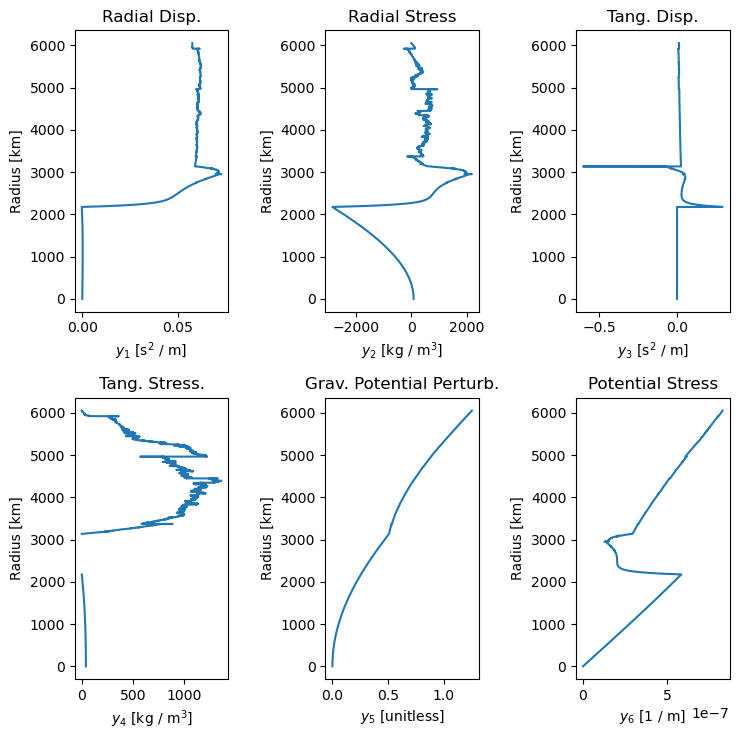

In [7]:
tidal_y = radial_solver(*function_inputs, **function_kwargs)

_ = yplot(tidal_y, radius_array)

In [4]:
tidal_y = radial_solver(*function_inputs, **function_kwargs)

_ = yplot(tidal_y, radius_array)

IntegrationFailed: Integration Solution Failed for layer 0 at solution #0.
	Required step size is less than spacing between numbers.

In [ ]:
tidal_y, load_y = radial_solver(*function_inputs, **function_kwargs_load)

_ = yplot([tidal_y, load_y], [radius_array, radius_array])

## Baseline

In [ ]:
# Scipy
# scipy RK45 - 95.6ms
# 107ms

tidal_y = radial_solver(*function_inputs, **function_kwargs)

_ = yplot(tidal_y, radius_array)

%timeit radial_solver(*function_inputs, **function_kwargs)

In [ ]:
# CyRK - Numba
# 10.2 ms
# 8.4 ms

tidal_y = radial_solver(*function_inputs, **function_kwargs_nb)

_ = yplot(tidal_y, radius_array)

%timeit radial_solver(*function_inputs, **function_kwargs_nb)

In [7]:
# NumbaLSODA
# 
tidal_y = radial_solver(*function_inputs, **function_kwargs_nblsoda)

_ = yplot(tidal_y, radius_array)

%timeit radial_solver(*function_inputs, **function_kwargs_nblsoda)

> n:\joe documents\research\software\tidalpy\tidalpy\utilities\integration\numbalsoda_helper.py(82)numbalsoda_solver()
     78 
     79         y_[i, :] = real_y + 1.0j * imag_y
     80 
     81     import pdb; pdb.set_trace()
---> 82     return t_eval, y_, success, message

ipdb> success
False
ipdb> solution
array([[-1.363e+57, -1.363e+57, -1.363e+57, ..., -1.363e+57, -1.363e+57,
        -1.363e+57],
       [-1.363e+57, -1.363e+57, -1.363e+57, ..., -1.363e+57, -1.363e+57,
        -1.363e+57],
       [-1.363e+57, -1.363e+57, -1.363e+57, ..., 7.426e-144, 2.595e+161,
        1.280e-152],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])
ipdb> solution.shape
(2174, 12)
ipdb> initial_condition_in
array([-3.469e-04, -7.077e-08, -5.328e+01, -1.157e-02, 3.681e-04,
     

In [6]:
%load_ext line_profiler

In [ ]:
%lprun -f radial_solver radial_solver(*function_inputs, **function_kwargs_nb)

In [ ]:
# TidalPy Pure Numba
# 7.94 ms
# 7 ms

tidal_y = tidal_y_solver_numba(*function_inputs, **function_kwargs_pure_nb)

_ = yplot(tidal_y, radius_array)

%timeit tidal_y_solver_numba(*function_inputs, **function_kwargs_pure_nb)

In [ ]:
# CyRK - Cython
# RK45 = 81.8 ms
# DOP853 = 118ms
# RK23 = 

tidal_y = radial_solver(*function_inputs, **function_kwargs_cy)

_ = yplot(tidal_y, radius_array)

%timeit radial_solver(*function_inputs, **function_kwargs_cy)

In [ ]:
# Julia
# RK45 = 897 ms
# Tsit5 = 171ms

tidal_y = radial_solver(*function_inputs, **function_kwargs_jl)

_ = yplot(tidal_y, radius_array)

%timeit radial_solver(*function_inputs, **function_kwargs_jl)